# Seasonal Regression of RePEc Weekly Tweet Count

This notebook aims to perform a seasonal regressional on the tweets in the RePEc database. We want to determine the effect of the season on number of tweets, along with decomposing the overall trend and residual data. The underyling goal however, is to confirm that the drop in tweets at the beggining of 2023 is not encapsulated by a seasonal drop.

## Objectives

1. Analyze the weekly tweets timeseries graph.
2. Detrend the data by applying a logarithmic scale.
3. Decomopse the timeseries data to identify the trend, seasonal, and residual components.
4. Analyze the seasonal component, and it's effect on our original graph.

**Author: Eric Uehling**  
*Date: 3.14.24*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the dataset
df = pd.read_csv('../data/csv/cleaned_RePEc_tweets.csv', dtype={'referenced_id': str, 'id': str, 'author_id': str})
df = df.drop('text', axis=1)

# Display the first few rows of the dataframe
df.head()

C:\Users\Eric\AppData\Local\Temp\ipykernel_18528\1995724337.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/csv/cleaned_RePEc_tweets.csv', dtype={'referenced_id': str, 'id': str, 'author_id': str})


,RePEc_id,author_id,id,created_at,retweet_count,reply_count,like_count,quote_count,impression_count,referenced_id,referenced_type,lang
0,Cpal276,766166816922173440,1636234884212506625,2023-03-16 05:16:10+00:00,0,0,0,0,18.0,NaN,own,fr
1,pal276,766166816922173440,1635542184387842048,2023-03-14 07:23:38+00:00,0,0,1,0,14.0,NaN,own,en
2,pal276,766166816922173440,1635539997033119744,2023-03-14 07:14:56+00:00,0,0,0,0,14.0,NaN,own,en
3,pal276,766166816922173440,1635536943521095680,2023-03-14 07:02:48+00:00,0,0,0,0,21.0,NaN,own,en
4,pal276,766166816922173440,1635534446593200129,2023-03-14 06:52:53+00:00,0,0,0,0,11.0,NaN,own,en


## Time Series Analysis of Tweets

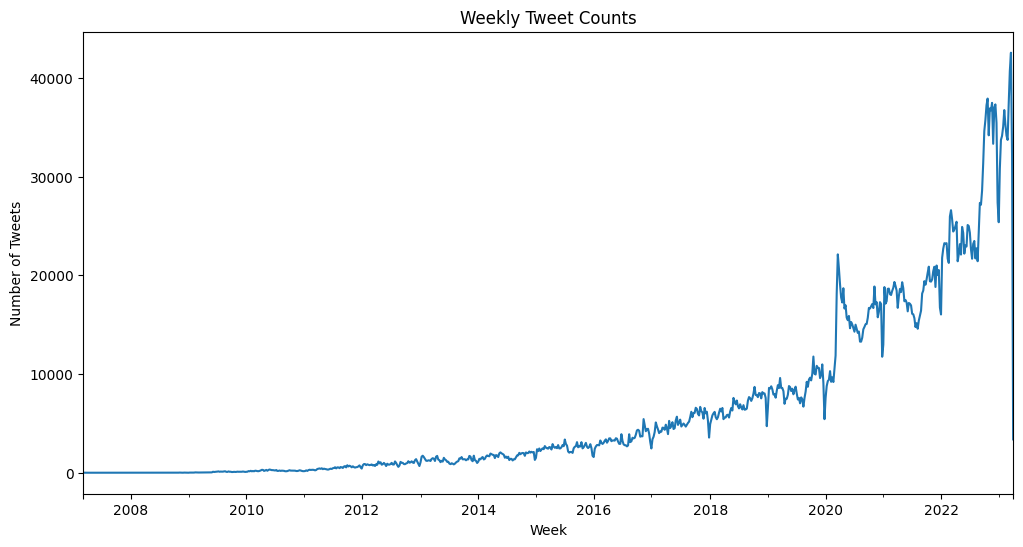

In [2]:
# Convert 'created_at' to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])

# Resampling to a weekly basis and counting tweets
weekly_tweets = df.resample('W', on='created_at').size()

# Plotting the time series of tweet counts
plt.figure(figsize=(12, 6))
weekly_tweets.plot(title='Weekly Tweet Counts')
plt.xlabel('Week')
plt.ylabel('Number of Tweets')
plt.show()

# Seasonal Analysis of Weekly Tweet Counts
In this section, we will analyze the weekly_tweets time series to understand the impact of seasonal effects on tweet counts. Given the visible trend in the data, it is essential to first detrend the series before examining the seasonal component to avoid conflating trend with seasonality.

## Step 1: Detrending the Data
We begin by detrending the data to focus on the seasonal and irregular components. One common approach to detrending is to apply a log transformation, which can help stabilize the variance in a time series with exponential growth.

In [3]:
# Convert 'created_at' to datetime format and set it as the index
df['created_at'] = pd.to_datetime(df['created_at'])
df.set_index('created_at', inplace=True)

# Resample the data to a weekly frequency, counting the number of tweets
weekly_tweets = df.resample('W').size()

# Add a small constant (1) before taking the log to avoid log(0)
weekly_tweets_log = np.log(weekly_tweets + 1)

# Check for any infinities or NaNs resulting from the transformation
weekly_tweets_log.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop any remaining NaNs from the series (or you could use interpolation)
weekly_tweets_log.dropna(inplace=True)

## Step 2: Seasonal Decomposition
With the log-transformed data, we can decompose the series into its trend, seasonal, and residual components using an additive model, which is suitable for data after log transformation.

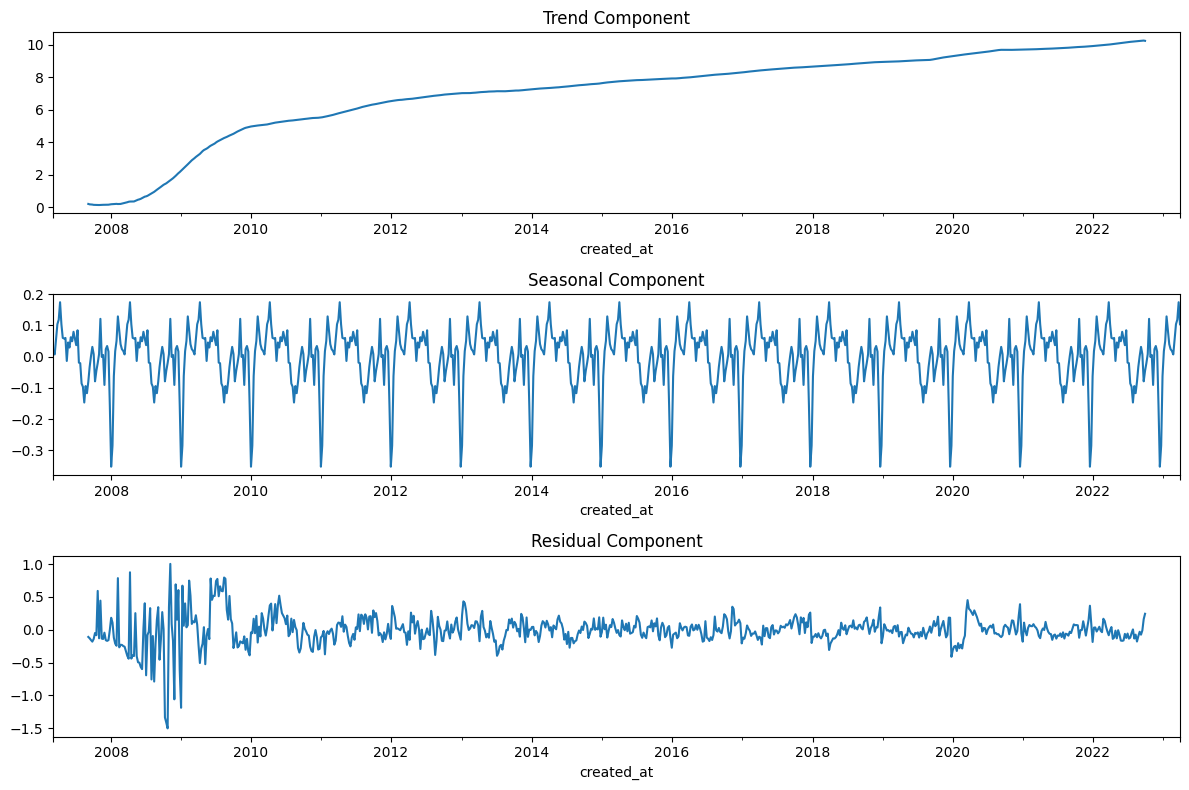

In [4]:
# Decompose the cleaned, log-transformed time series
decomposition = seasonal_decompose(weekly_tweets_log, model='additive', period=52)

# Plot the decomposed components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
decomposition.trend.plot(ax=ax1, title='Trend Component')
decomposition.seasonal.plot(ax=ax2, title='Seasonal Component')
decomposition.resid.plot(ax=ax3, title='Residual Component')
plt.tight_layout()
plt.show()


## Step 3: Analyzing Seasonal Component
After decomposing the series, we specifically focus on the seasonal component to analyze the patterns that repeat over known, fixed periods of time.

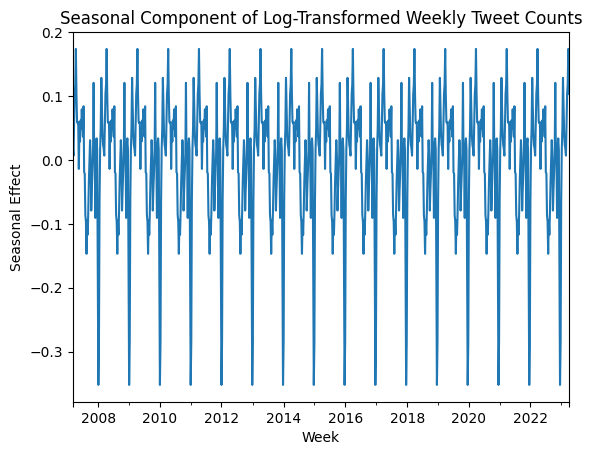

In [5]:
# Plot just the seasonal component
decomposition.seasonal.plot(title='Seasonal Component of Log-Transformed Weekly Tweet Counts')
plt.xlabel('Week')
plt.ylabel('Seasonal Effect')
plt.show()

# Analysis of Seasonal Effects

In this section, we will graphically explore the seasonal effects as captured by our seasonal ARIMA model. Understanding these effects is crucial for interpreting the data's underlying patterns beyond simple trends. We will visualize:
1. The seasonal effect as attributed by the model, for both log-transformed and original data scales.
2. The original weekly tweet counts alongside a new graph that removes the seasonal effect, providing a clearer view of the data's underlying trends and irregularities.

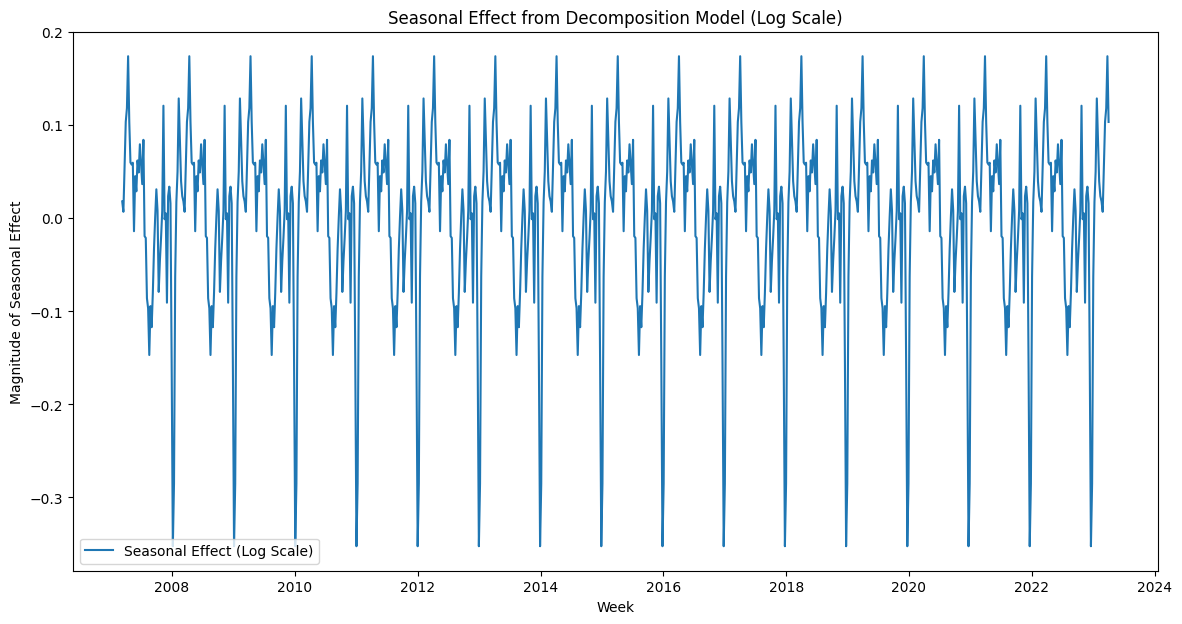

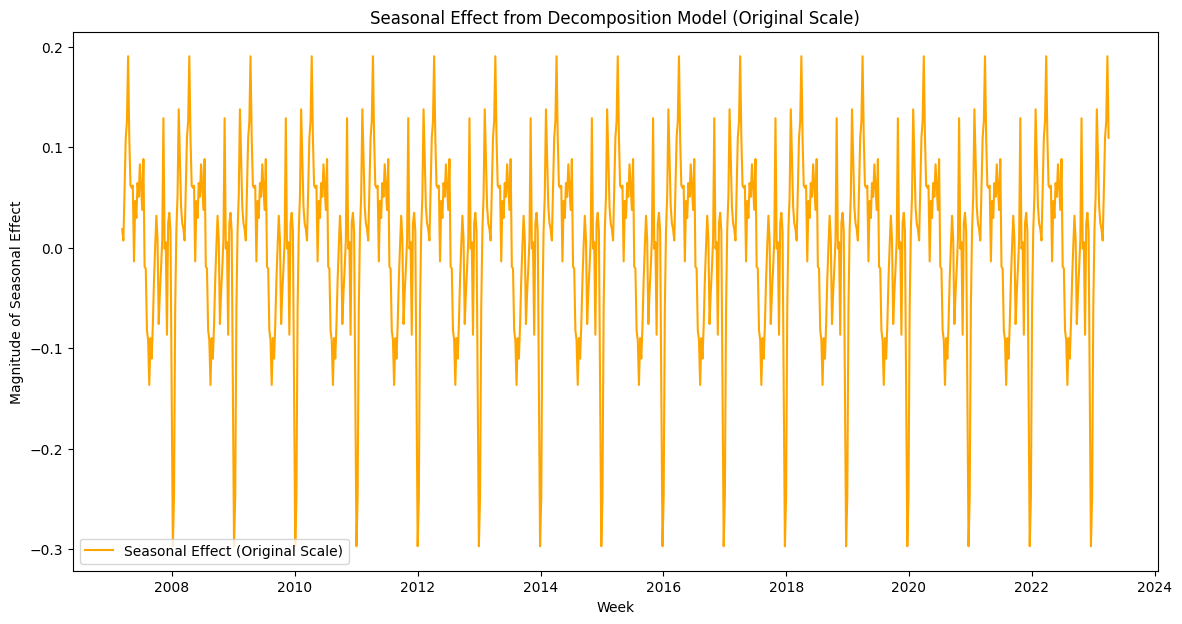

In [6]:
# Graphing the seasonal effect (log scale)
plt.figure(figsize=(14, 7))
plt.plot(decomposition.seasonal.index, decomposition.seasonal, label='Seasonal Effect (Log Scale)')
plt.title('Seasonal Effect from Decomposition Model (Log Scale)')
plt.xlabel('Week')
plt.ylabel('Magnitude of Seasonal Effect')
plt.legend()
plt.show()

# Converting the seasonal effect to the original scale (exponential)
seasonal_effect_original_scale = np.exp(decomposition.seasonal) - 1

# Graphing the seasonal effect (original scale)
plt.figure(figsize=(14, 7))
plt.plot(decomposition.seasonal.index, seasonal_effect_original_scale, label='Seasonal Effect (Original Scale)', color='orange')
plt.title('Seasonal Effect from Decomposition Model (Original Scale)')
plt.xlabel('Week')
plt.ylabel('Magnitude of Seasonal Effect')
plt.legend()
plt.show()

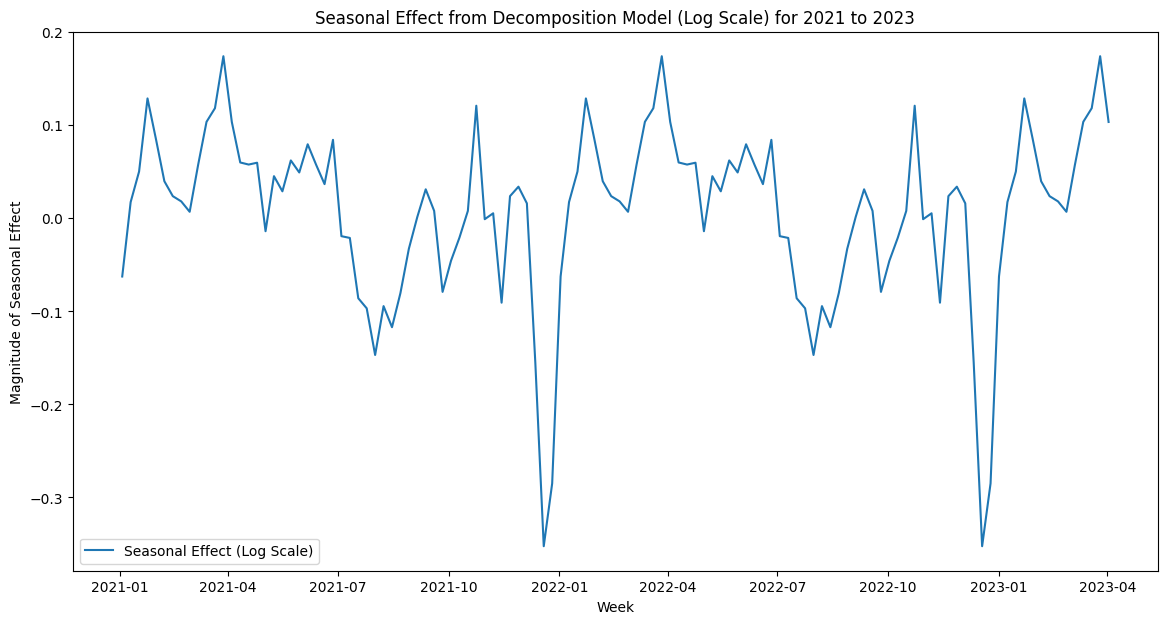

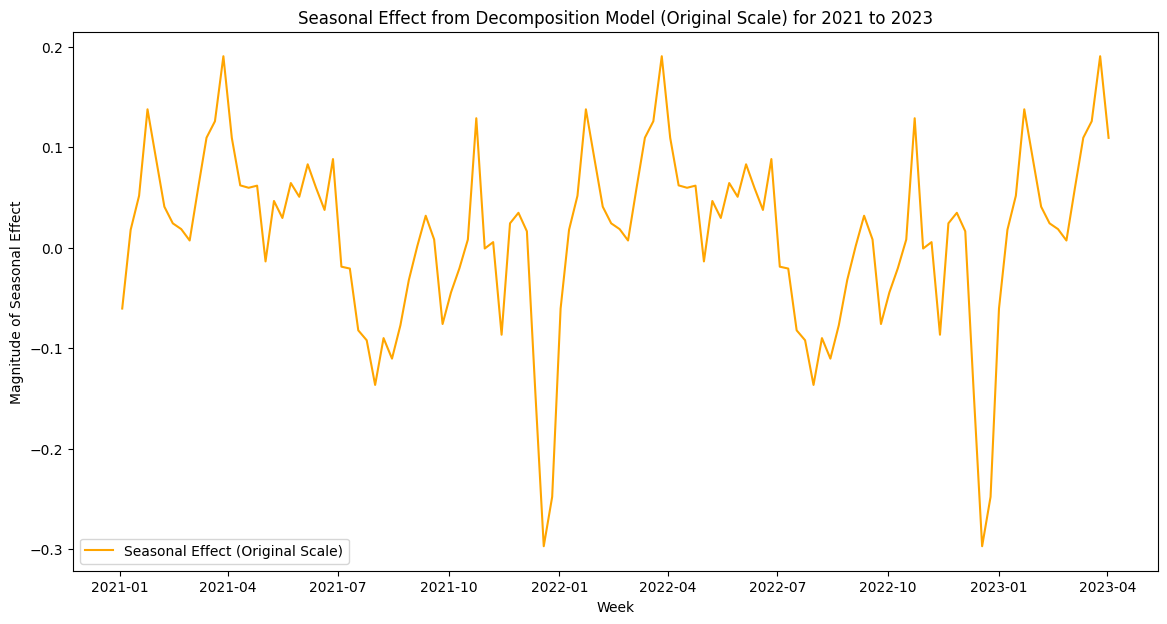

In [7]:
# Filter the seasonal component for the period from 2021 to 2023
seasonal_2021_2023 = decomposition.seasonal['2021':'2023']

# Graphing the seasonal effect (log scale) for the period 2021 to 2023
plt.figure(figsize=(14, 7))
plt.plot(seasonal_2021_2023.index, seasonal_2021_2023, label='Seasonal Effect (Log Scale)')
plt.title('Seasonal Effect from Decomposition Model (Log Scale) for 2021 to 2023')
plt.xlabel('Week')
plt.ylabel('Magnitude of Seasonal Effect')
plt.legend()
plt.show()

# Converting the seasonal effect to the original scale (exponential) for 2021 to 2023
seasonal_effect_original_scale_2021_2023 = np.exp(seasonal_2021_2023) - 1

# Graphing the seasonal effect (original scale) for the period 2021 to 2023
plt.figure(figsize=(14, 7))
plt.plot(seasonal_2021_2023.index, seasonal_effect_original_scale_2021_2023, label='Seasonal Effect (Original Scale)', color='orange')
plt.title('Seasonal Effect from Decomposition Model (Original Scale) for 2021 to 2023')
plt.xlabel('Week')
plt.ylabel('Magnitude of Seasonal Effect')
plt.legend()
plt.show()

# Comparing Original and Seasonally Adjusted Time Series

To further dissect the influence of seasonal variations on tweet activity, we will compare the original weekly tweet counts with a version of the series that has the seasonal effects removed. This comparison aims to highlight the true underlying patterns in the data, isolating them from seasonal fluctuations. We will perform this analysis on both log-transformed and original scales to accommodate different data characteristics.

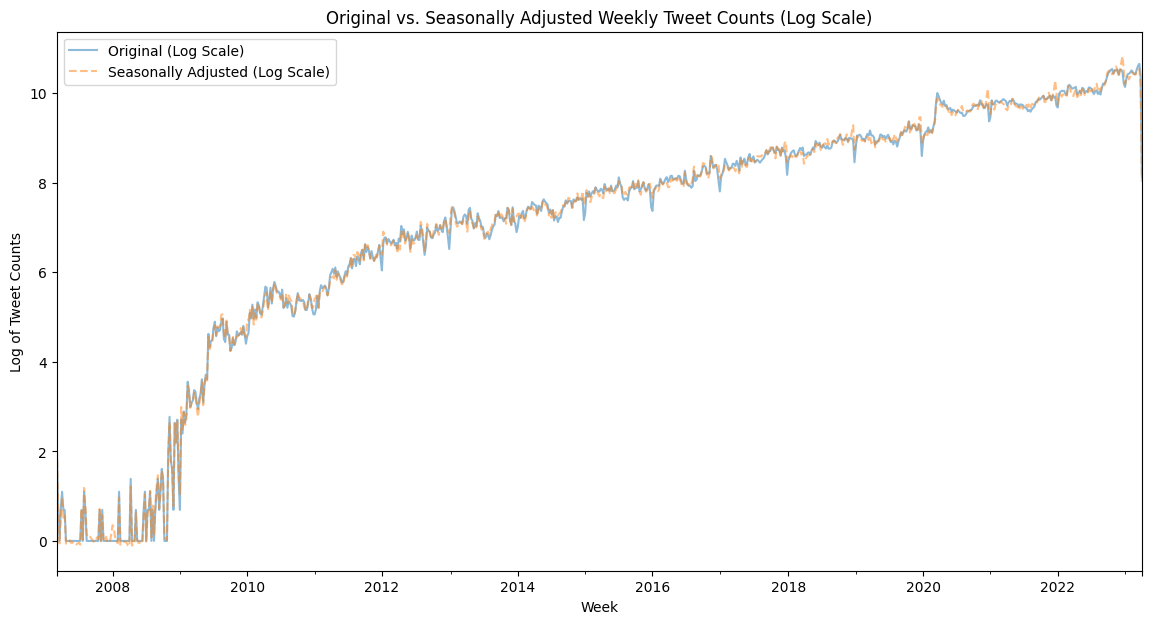

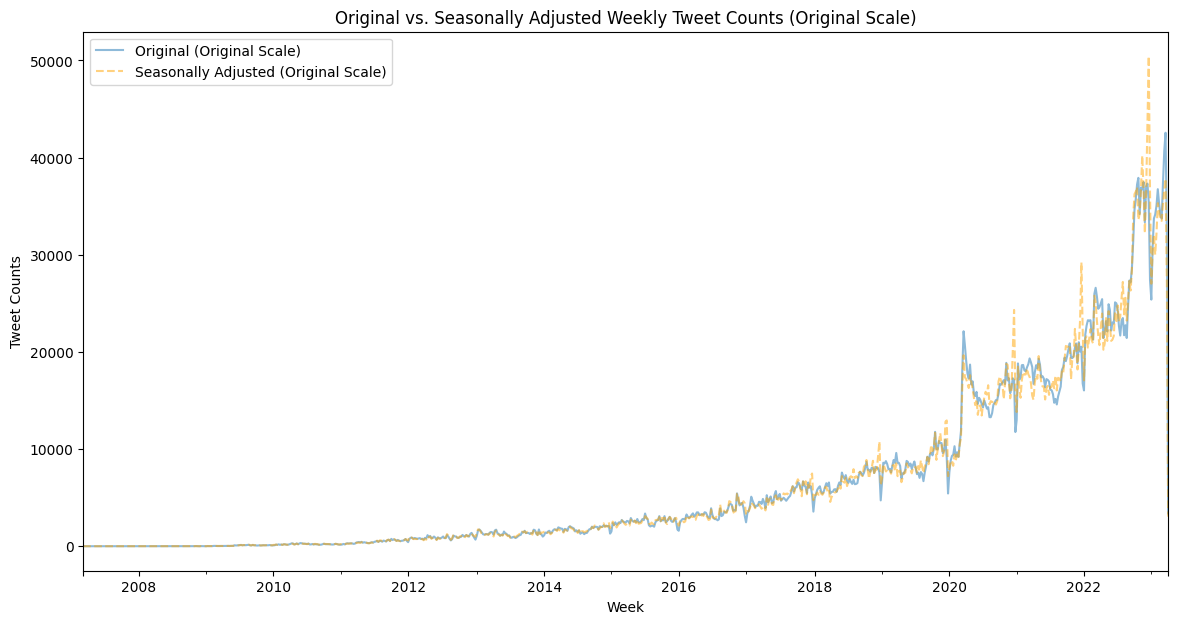

In [8]:
# Removing the seasonal effect from the log-transformed series
weekly_tweets_log_adjusted = weekly_tweets_log - decomposition.seasonal

# Graphing the original vs. seasonally adjusted series (log scale)
plt.figure(figsize=(14, 7))
weekly_tweets_log.plot(label='Original (Log Scale)', alpha=0.5)
weekly_tweets_log_adjusted.plot(label='Seasonally Adjusted (Log Scale)', alpha=0.5, linestyle='--')
plt.title('Original vs. Seasonally Adjusted Weekly Tweet Counts (Log Scale)')
plt.xlabel('Week')
plt.ylabel('Log of Tweet Counts')
plt.legend()
plt.show()

# Converting the seasonally adjusted series back to the original scale
weekly_tweets_original_adjusted = np.exp(weekly_tweets_log_adjusted) - 1

# Graphing the original vs. seasonally adjusted series (original scale)
plt.figure(figsize=(14, 7))
weekly_tweets.plot(label='Original (Original Scale)', alpha=0.5)
weekly_tweets_original_adjusted.plot(label='Seasonally Adjusted (Original Scale)', alpha=0.5, linestyle='--', color='orange')
plt.title('Original vs. Seasonally Adjusted Weekly Tweet Counts (Original Scale)')
plt.xlabel('Week')
plt.ylabel('Tweet Counts')
plt.legend()
plt.show()

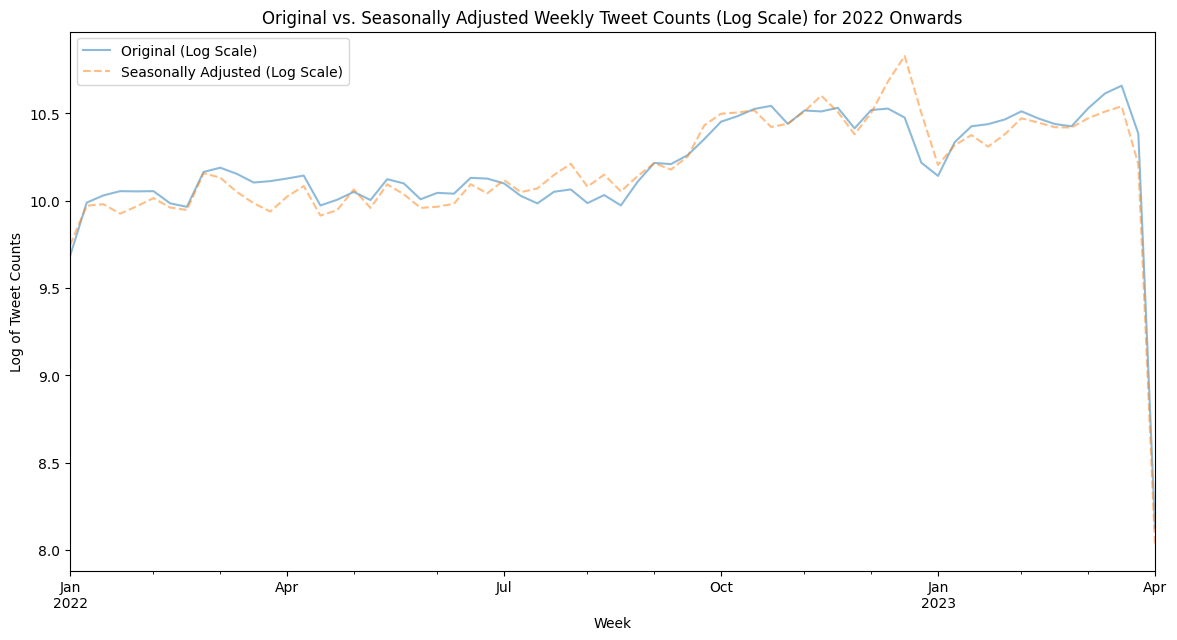

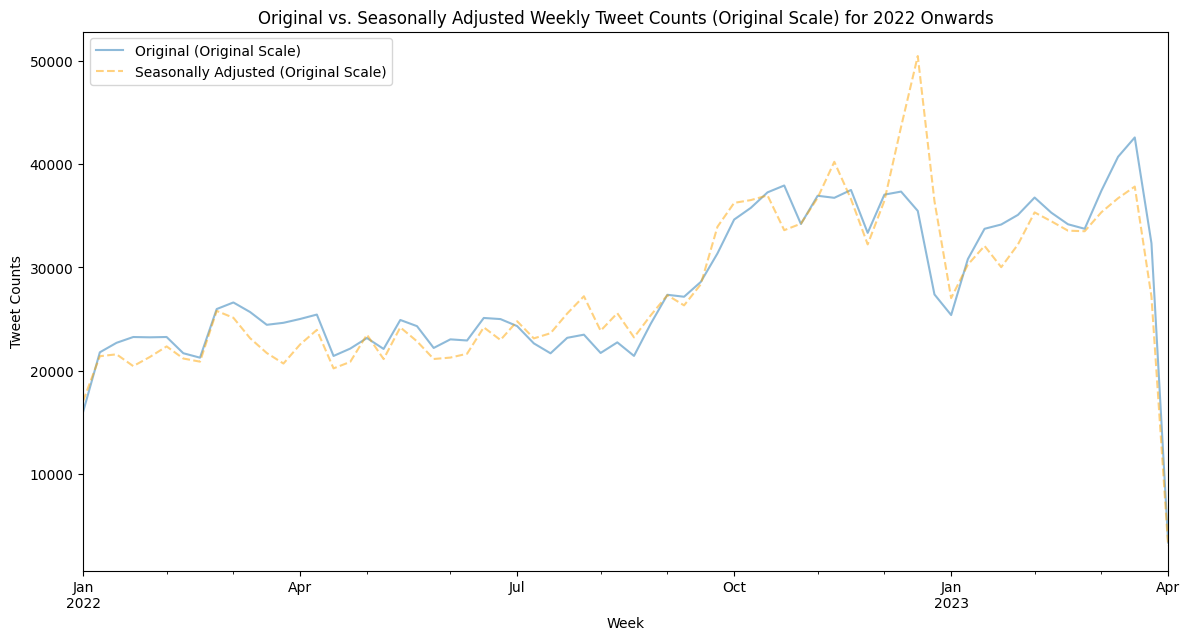

In [9]:
weekly_tweets_log_2022 = weekly_tweets_log['2022':]
seasonal_2022 = decomposition.seasonal['2022':]

# Adjust the series by removing the seasonal component for 2022 onwards
weekly_tweets_log_adjusted_2022 = weekly_tweets_log_2022 - seasonal_2022

# Graphing the original vs. seasonally adjusted series (log scale) for 2022 onwards
plt.figure(figsize=(14, 7))
weekly_tweets_log_2022.plot(label='Original (Log Scale)', alpha=0.5)
weekly_tweets_log_adjusted_2022.plot(label='Seasonally Adjusted (Log Scale)', alpha=0.5, linestyle='--')
plt.title('Original vs. Seasonally Adjusted Weekly Tweet Counts (Log Scale) for 2022 Onwards')
plt.xlabel('Week')
plt.ylabel('Log of Tweet Counts')
plt.legend()
plt.show()

# Converting the seasonally adjusted series back to the original scale for 2022 onwards
weekly_tweets_original_adjusted_2022 = np.exp(weekly_tweets_log_adjusted_2022) - 1

# Assuming weekly_tweets is also preloaded, filter it for 2022 onwards for comparison
weekly_tweets_2022 = weekly_tweets['2022':]

# Graphing the original vs. seasonally adjusted series (original scale) for 2022 onwards
plt.figure(figsize=(14, 7))
weekly_tweets_2022.plot(label='Original (Original Scale)', alpha=0.5)
weekly_tweets_original_adjusted_2022.plot(label='Seasonally Adjusted (Original Scale)', alpha=0.5, linestyle='--', color='orange')
plt.title('Original vs. Seasonally Adjusted Weekly Tweet Counts (Original Scale) for 2022 Onwards')
plt.xlabel('Week')
plt.ylabel('Tweet Counts')
plt.legend()
plt.show()